In [1]:
from rich import inspect
import numpy as np 
import PIL
import matplotlib.pyplot as plt

import torch 
import torchvision

import skimage

import sys
sys.path.append('..')

import pytorch_lightning as pl 

from obspy.io.segy.segy import _read_segy


from models.denoising_autoencoder import LitAutoEncoder
from datamodules.segy_data_module import SEGYDataModule
from utils.smoothed_tiled_predictions import predict_img_with_smooth_windowing
from noise.random_noise import add_random_noise

import gc

In [2]:
patch_size = 40
noise_factor = 0.5 
segy_path = '../data/MP36-08_PSTM_STK.sgy'

In [3]:
# convert sgy to npy 
stream = _read_segy(segy_path)
data = np.stack(t.data for t in stream.traces)
data = data.T

# height and width of segy
h,w = data.shape

# remove outliers
vm = np.percentile(np.abs(data), 99)
data = np.clip(data, -1 * vm, 1 * vm )

# calculate statistics 
data_mean = np.mean(data)
data_std = np.std(data)
data_min = np.min(data)
data_max = np.max(data)

#standardise data
norm_data = (data - data_mean)/data_std

# add noise 
noisy_data = add_random_noise(data, noise_factor)

/geofs/home/hwjayb/anaconda3/envs/lightning/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3318: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if await self.run_code(code, result, async_=asy):


In [4]:
noisy_data.shape

(3001, 2649)

In [5]:
checkpoint_path = '/geofs/home/hwjayb/denoising_research/evaluation_of_seismic_denoising/experiments/lightning_logs/autoencoder/dae_noise_0.5_16_11_2022_15_47_38_standardised/checkpoints/epoch=109-step=14960.ckpt'


def predict_func(input_image) : # B,H,W,C
    
    with torch.no_grad() : 
        model = LitAutoEncoder().load_from_checkpoint(checkpoint_path)
        model.eval()

        input_image = torch.Tensor(np.transpose(input_image, (0,3,1,2))) # B,C,H,W
        img_tensor = torch.Tensor(input_image)
        input_image = None 
        gc.collect()
        
        prediction = model(img_tensor)
        img_tensor = None 
        gc.collect()

        result = np.transpose(prediction.numpy(), (0,2,3,1))
        
        gc.collect()
        
        return result # B,H,W,C

In [6]:
noisy_data_c = np.expand_dims(noisy_data,-1) # H,W,C

clean_image = predict_img_with_smooth_windowing(noisy_data_c,patch_size,2,1,predict_func)

  0%|                                                                                                                                                                                                                                                                                                                                                                      | 0/8 [00:00<?, ?it/s]/geofs/home/hwjayb/anaconda3/envs/lightning/lib/python3.9/site-packages/torch/nn/modules/conv.py:442: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  /opt/conda/conda-bld/pytorch_1640811803361/work/aten/src/ATen/native/Convolution.cpp:647.)
  return F.conv2d(input, weight, bias, self.stride,
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

In [7]:
clean_image = np.squeeze(clean_image)

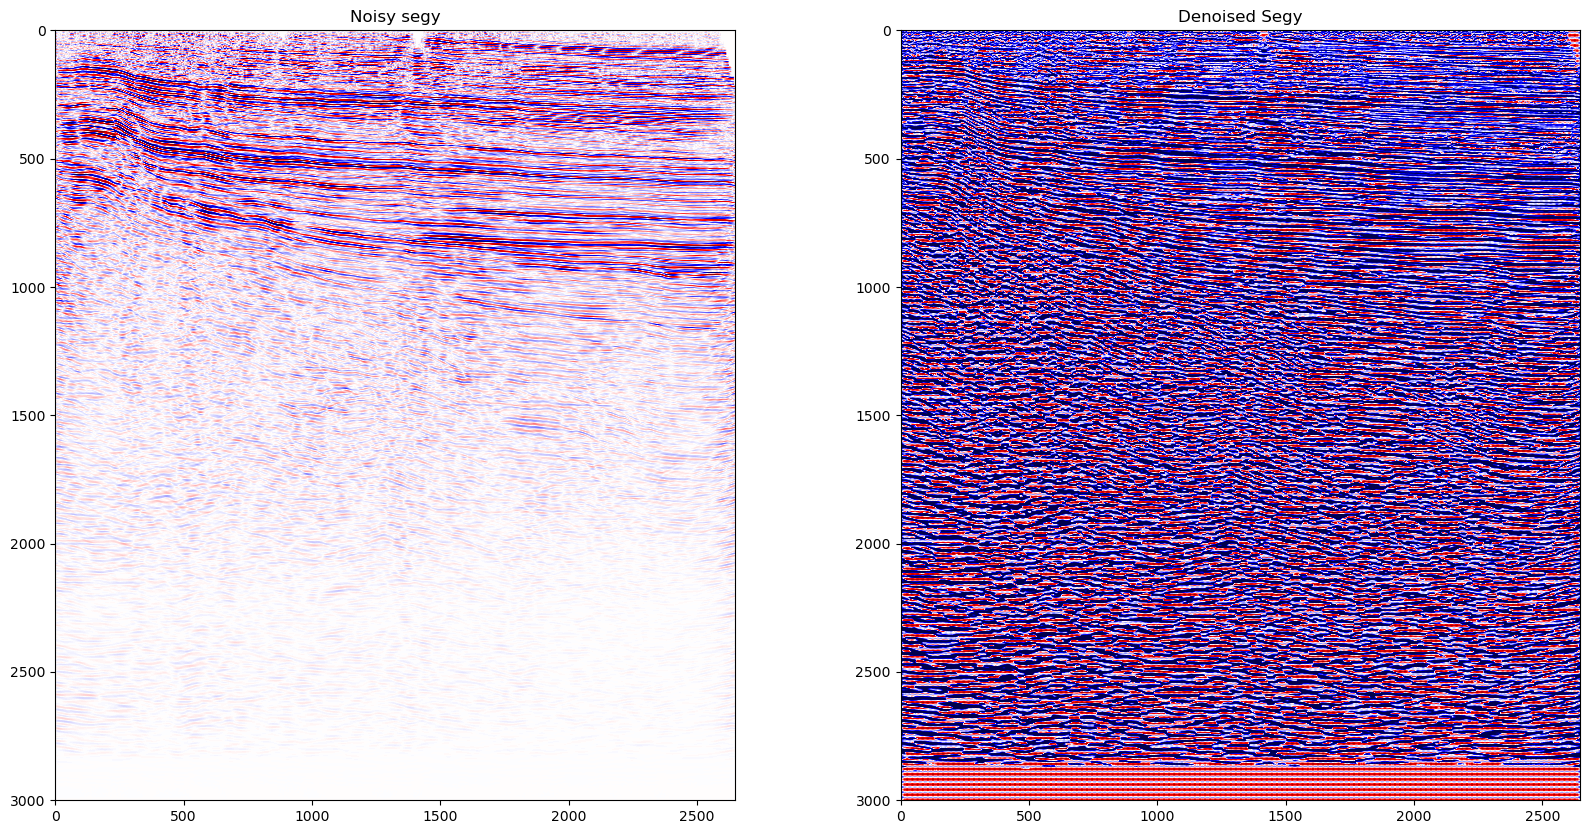

In [8]:
fig,ax = plt.subplots(1,2,figsize=(20,10))
ax[0].set_title("Noisy segy")
ax[0].imshow(noisy_data, cmap='seismic')
ax[1].set_title("Denoised Segy")
ax[1].imshow(clean_image/3, cmap='seismic')
plt.show()

In [9]:
noisy_data_c = np.expand_dims(noisy_data,-1) # H,W,C

clean_image = predict_img_with_smooth_windowing(noisy_data_c,patch_size,4,1,predict_func)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [02:30<00:00, 18.81s/it]


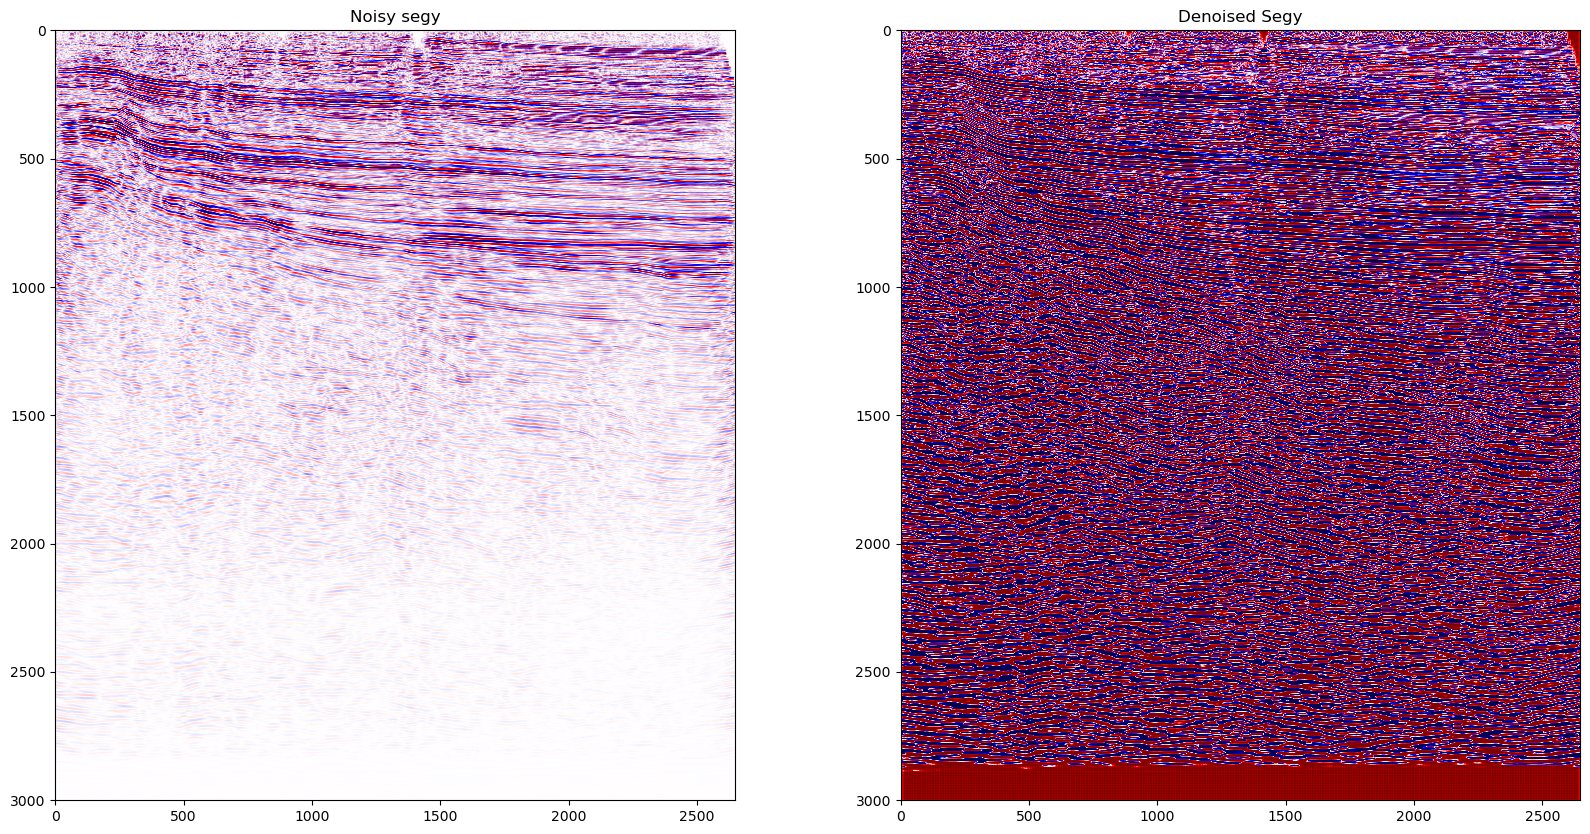

In [10]:
fig,ax = plt.subplots(1,2,figsize=(20,10))
ax[0].set_title("Noisy segy")
ax[0].imshow(noisy_data, cmap='seismic')
ax[1].set_title("Denoised Segy")
ax[1].imshow(clean_image/3, cmap='seismic')
plt.show()

Note that smoothing works wells and improves with increasing subdivisions per patch_window.

In [11]:
noisy_data_c = np.expand_dims(noisy_data,-1) # H,W,C

clean_image = predict_img_with_smooth_windowing(noisy_data_c,patch_size,8,1,predict_func)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [43:49<00:00, 328.68s/it]


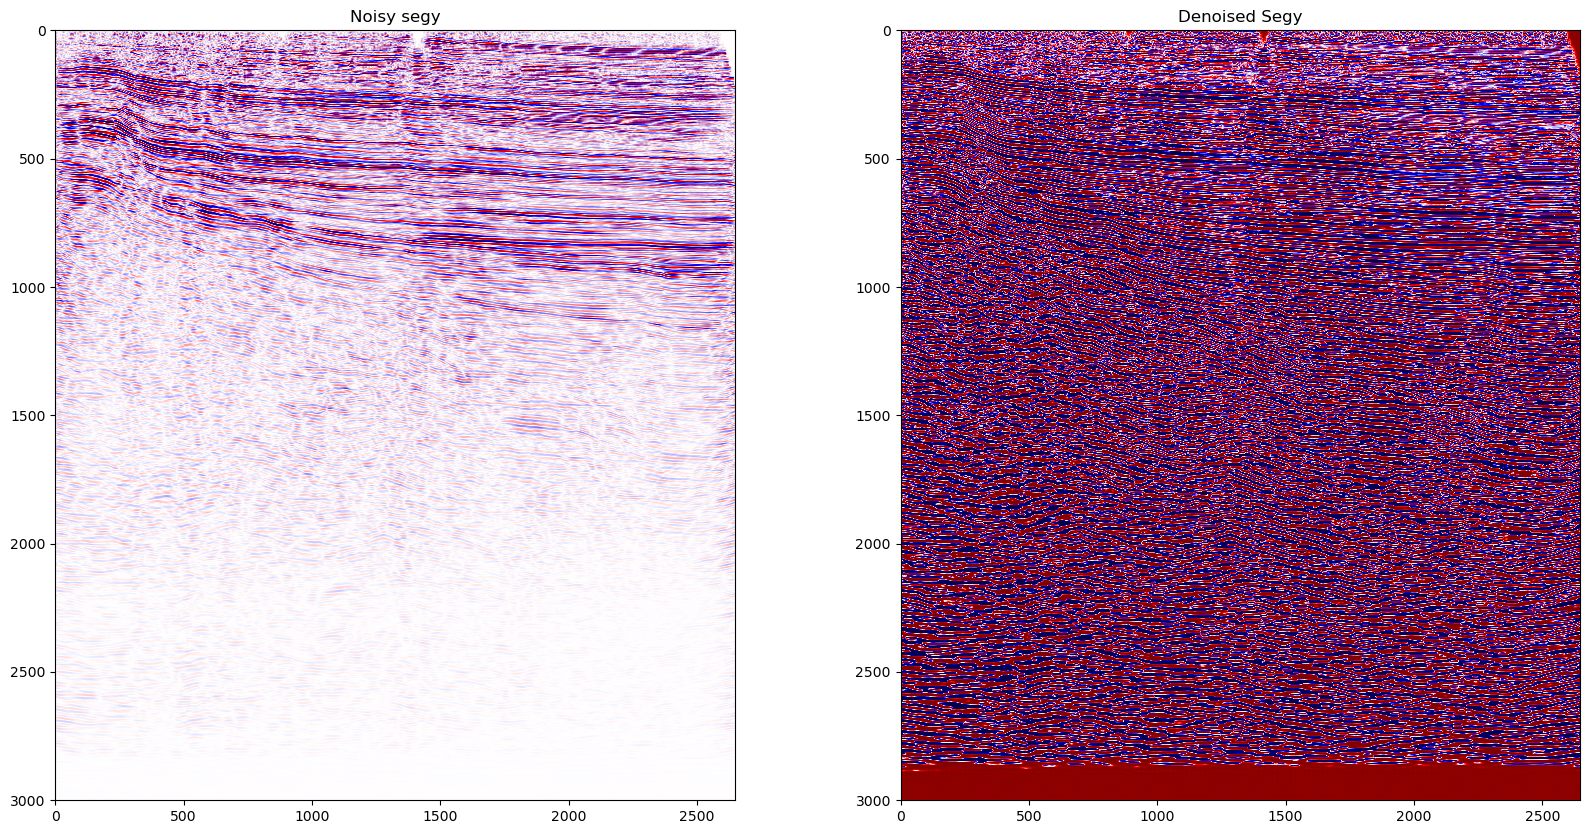

In [12]:
fig,ax = plt.subplots(1,2,figsize=(20,10))
ax[0].set_title("Noisy segy")
ax[0].imshow(noisy_data, cmap='seismic')
ax[1].set_title("Denoised Segy")
ax[1].imshow(clean_image/3, cmap='seismic')
plt.show()